# KITTI Dataset Exploration

In [2]:
# Extract all libraries needed here
import numpy as np
import pykitti
import matplotlib.pyplot as plt

from source import parseTrackletXML as xmlParser
from source import dataset_utility as du
import utilities as ut
import projection as proj
#import draw_point_cloud as pc
import ground_plane_segmentation as sg

%matplotlib inline  


In [3]:
# Store all parameters here

# Change this to the directory where you store KITTI data
basedir = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"


In [4]:
date = '2011_09_26'
drive = '0048'
dataset = ut.load_dataset(basedir,date, drive,calibrated=True)


directory = "/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset"
tracklet_rects, tracklet_types = ut.load_tracklets_for_frames(len(list(dataset.velo)), '{}/{}/{}_drive_{}_sync/tracklet_labels.xml'.format(directory,date, date, drive))


Drive: 2011_09_26_drive_0048_sync

Frame range: None

IMU-to-Velodyne transformation:
[[ 1.      0.0008 -0.002  -0.8087]
 [-0.0008  0.9999 -0.0148  0.3196]
 [ 0.002   0.0148  0.9999 -0.7997]
 [ 0.      0.      0.      1.    ]]

Gray stereo pair baseline [m]: 0.537150600501

RGB stereo pair baseline [m]: 0.532725440079
Parsing tracklet file /Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/2011_09_26_drive_0048_sync/tracklet_labels.xml
File contains 8 tracklets
Loaded 8 tracklets.
[<source.parseTrackletXML.Tracklet object at 0x10cd69208>, <source.parseTrackletXML.Tracklet object at 0x10cd69240>, <source.parseTrackletXML.Tracklet object at 0x10cd69278>, <source.parseTrackletXML.Tracklet object at 0x10cd692b0>, <source.parseTrackletXML.Tracklet object at 0x10cd692e8>, <source.parseTrackletXML.Tracklet object at 0x10cd69320>, <source.parseTrackletXML.Tracklet object at 0x10cd69358>, <source.parseTrackletXML.Tracklet object at 0x10cd69390>]
[<

#####

3d Point Cloud Projection on Camera Image

#####

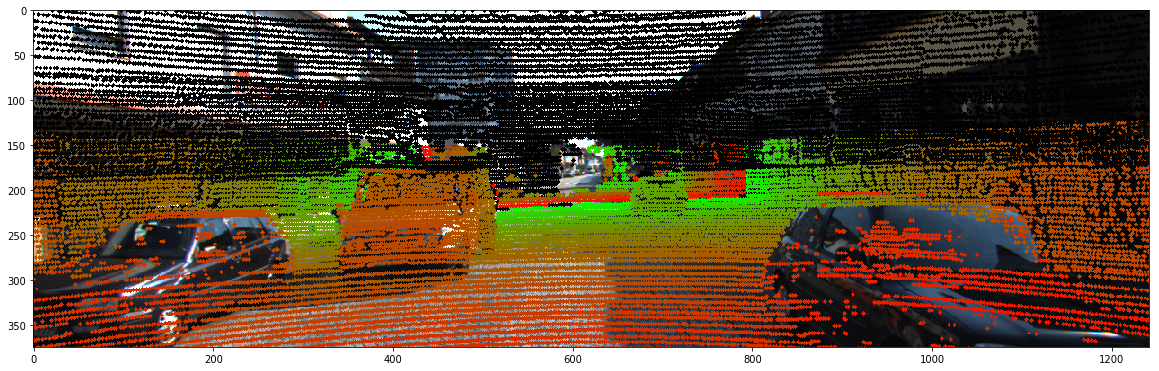

In [5]:
# Submissions #1  - 3d cloud point on camera

import cv2
import statistics
import sys

# Get velodyne points and camera images
dataset_velo = list(dataset.velo)
dataset_rgb = list(dataset.rgb)

# Set parameters
#velodyne_max_x=100  # this scales the x-axis values. maybe replace with range
frame = 0 # the frame that we are interested in
include_z = True # include x-axis for velodyne points. this is mostly used for color coding the velodyne points
radius = 2 # the radius of the circle
calib_dir ="/Users/davidwoo/Documents/Projects/self-driving-cars/plane-segmentation/KITTI-Dataset/2011_09_26/"
calib_file = calib_dir + "calib_velo_to_cam.txt"

# Convert velodyne coordinates to pixel coordinates
velo_image_data,velo_data_raw_sampled = proj.convert_velo_cord_to_img_cord_test(dataset_velo[0],calib_dir)

rgb_img = dataset_rgb[frame][frame]
                              #
# Crop velodyne points outside of image size. Velodyne points might cover wider range than image 
corped_velo_data = proj.crop_to_img_size([400,1500,3], velo_image_data,velo_data_raw_sampled)

result_img = proj.overlay_velo_img(rgb_img, corped_velo_data,radius)
plt.imshow(result_img)
    


#####

Tracklets on Camera Image ( 2-d bounding boxes)

#####

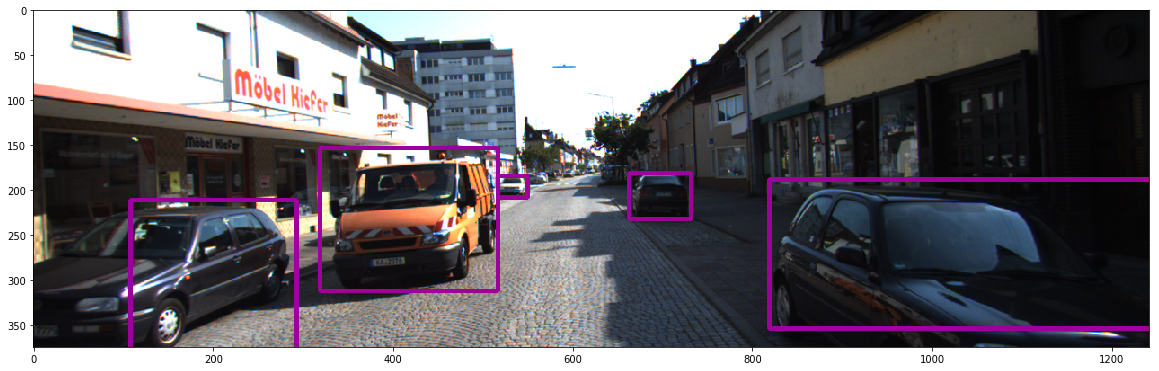

In [6]:
####2d box projection ####

#load velodyne and images
dataset_rgb = list(dataset.rgb)
rgb_img = dataset_rgb[frame][frame]
dataset_velo = list(dataset.velo)

#settings
max_iter = 0
frame = 0
tracklet = 0

for rect in tracklet_rects[frame]:
    
    dataset_tracklets = rect.transpose(1,0)
    
    velo_data_tracklets = proj.convert_velo_cord_to_img_cord_test(dataset_tracklets, calib_dir,2,True)

    corped_velo_data_tracklets = proj.crop_to_img_size([400,1500,3], velo_data_tracklets,dataset_velo[0])

    cv2.rectangle(rgb_img, 
                  (int(min(corped_velo_data_tracklets[0])),int(min(corped_velo_data_tracklets[1]))),
                  (int(max(corped_velo_data_tracklets[0])),int(max(corped_velo_data_tracklets[1]))), 
                  (100,255,100), 3)

fig1 = plt.figure(figsize=(20, 20))
plt.imshow(rgb_img)

#####

Ground Plane Segmentation

#####

goal_inliers % 4798.8
angle % 0.0402419120175
took iterations: 9 best model: [-0.0085  0.0174  0.4812  0.8764] explains: 8101
plotting chart


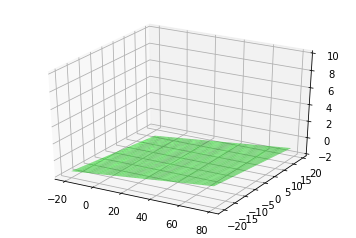

In [7]:
%matplotlib inline

#sample velodyne data in equal increments
frame = 0
dataset_velo = list(dataset.velo)
velo_data= dataset_velo[frame][:, :] 

# ransac parameters
n = int(velo_data.shape[0] * 0.1)
max_iterations = 100
goal_inliers = n * 0.4
inlier_threshold = 0.01
print("goal_inliers %",goal_inliers)

# approximately normal to z-axis
reference_vector =[0,0,1]

#m, b, adj_velo_frame = sg.run_ransac(velo_frame, lambda x, y: is_inlier(x, y, 0.01), int(velo_frame.shape[0] * 0.1), goal_inliers, max_iterations,reference_vector)
m, b, adj_velo_frame = sg.ransac(velo_data, inlier_threshold, n,
                                 goal_inliers, max_iterations,reference_vector)
a, b, c, d = m
xx, yy, zz = sg.plot_plane(a, b, c, d)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim3d(-2, 10)
ax.plot_surface(xx, yy, zz, color=(0, 1, 0, 0.5))


print("plotting chart")
plt.show()

10


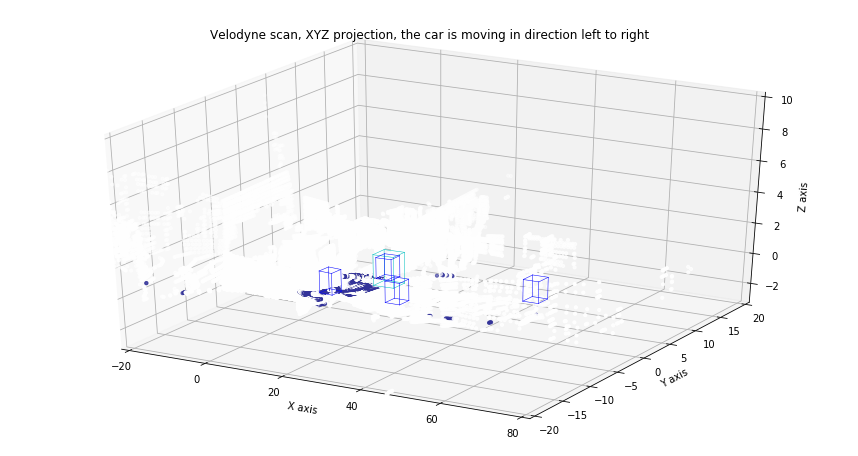

10


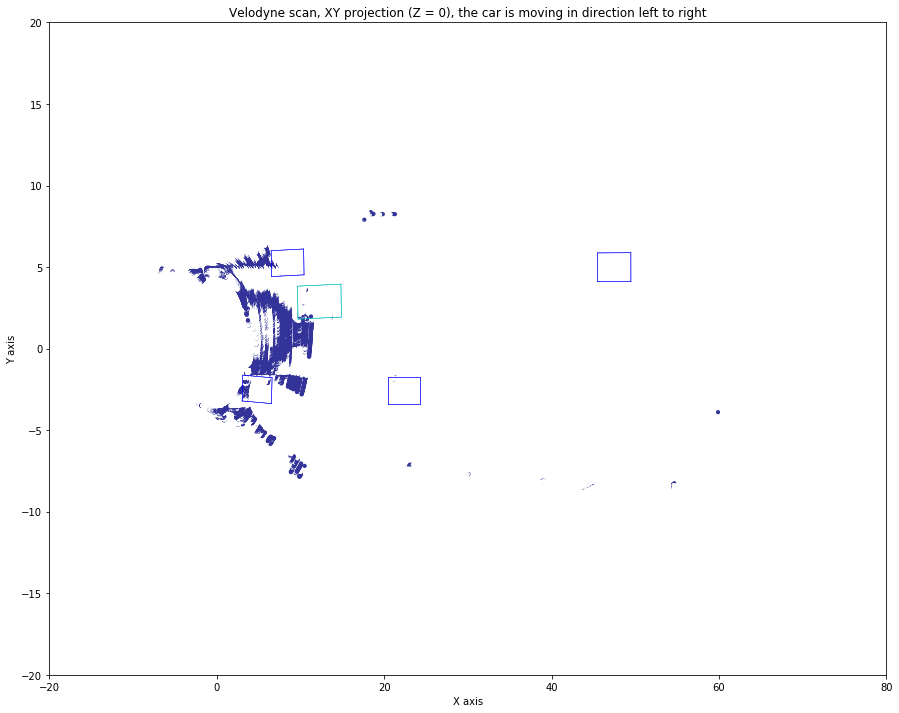

In [8]:
frame = 0
f = plt.figure(figsize=(15, 8))
ax2 = f.add_subplot(111, projection='3d') 

#f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
ut.draw_point_cloud_seg(adj_velo_frame,tracklet_rects, tracklet_types,frame,ax2,'Velodyne scan, XYZ projection, the car is moving in direction left to right')
plt.show()


f, ax3 = plt.subplots(1, 1, figsize=(15, 12))
ut.draw_point_cloud_seg(adj_velo_frame,tracklet_rects, tracklet_types,frame,
    ax3, 
    'Velodyne scan, XY projection (Z = 0), the car is moving in direction left to right', 
    axes=[0, 1] # X and Y axes
)
plt.show()